In [29]:
%pip install imutils
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import argparse
import ntpath
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import imutils
from imutils.video import WebcamVideoStream
from imutils import face_utils


import time

In [3]:
# to detect face feature
import dlib
predictor_model = 'shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()# dlib人脸检测器
predictor = dlib.shape_predictor(predictor_model)


In [4]:
def readFiles(path):
    img = cv2.imread(path)
    return img

In [5]:
detectors = {
    "eye": os.path.sep.join([ntpath.dirname(cv2.__file__), 'data', 'haarcascade_eye.xml']),
    "face": os.path.sep.join([ntpath.dirname(cv2.__file__), 'data', 'haarcascade_frontalface_default.xml'])
}
def detect(gray, part="face"):
    
    detector = cv2.CascadeClassifier(detectors[part])
    rects = detector.detectMultiScale(gray, scaleFactor=2, minNeighbors=5, minSize=(15, 15),
                                      flags=cv2.CASCADE_SCALE_IMAGE)
    return rects

In [65]:
heightResize = 480
framesSkipping = 2

cameraObject = cv2.VideoCapture(0)
ret, image = cameraObject.read()
height = image.shape[0]

frame_resize_scale = float(height)/heightResize
modelPath = "shape_predictor_68_face_landmarks.dat"

faceDetector = dlib.get_frontal_face_detector()
shapePredictor = dlib.shape_predictor(modelPath)


def Recording():
    count = 0
    # open webcam
    vs = WebcamVideoStream().start()
    start = time.time()
    fps = vs.stream.get(cv2.CAP_PROP_FPS)
    print("Frames per second using cv2.CAP_PROP_FPS : {0}".format(fps))

    while True:
        # turn to gray image to detect face
        frame = vs.read()
        img = frame.copy()
        img = imutils.resize(img, width=600)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        
        if (count % framesSkipping == 0):
            faces = faceDetector(img,0)
        for face in faces:
#             newRectValues = dlib.rectangle(int(face.left() * frame_resize_scale),
#                                int(face.top() * frame_resize_scale),
#                                int(face.right() * frame_resize_scale),
#                                int(face.bottom() * frame_resize_scale))
            predictor = shapePredictor(img, face)
            landmarks = np.matrix([[p.x, p.y] for p in predictor.parts()])
            faceMask = get_image_hull_mask(img, landmarks)
        img = cv2.bitwise_and(faceMask, img)
        cv2.imshow("Frame", img)

        count = count + 1
        # calculate framePerSecond at an interval of 100 frames
        if (count == 100):
            count = 0
        
        # 判斷是否案下"q"；跳離迴圈
        key = cv2.waitKey(1) & 0xff
        if key == ord('q'):
            break

    #  清除畫面與結束WebCam
    cv2.destroyAllWindows()
    vs.stop()


Recording()

Frames per second using cv2.CAP_PROP_FPS : nan


/var/folders/fl/0gvtd2b94r578g4v1cqx9vn40000gn/T/ipykernel_8345/1390692589.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_lmrks = np.array(image_landmarks, dtype=np.int)


In [6]:
def img2Gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray

In [7]:
def showImage(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [8]:
def GetFaceMask(img):
    img, Gimg = img2Gray(img)
    rects = detect(Gimg) # return multi-face
    
    # Face mask, cut out of face region
    Facemask = np.zeros_like(img)
    (y, x, w, h) = rects[0].astype("int")
    Facemask = cv2.rectangle(Facemask, (y,x), (y + w, x + h), (255,255,255), -1)
    
    return Facemask

In [24]:
def skinDetection(img):
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255)) 
    HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #converting from gbr to YCbCr color space
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    #skin color range for hsv color space 
    YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135)) 
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #merge skin detection (YCbCr and hsv)
    global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
    global_mask=cv2.medianBlur(global_mask,3)
    global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))


    HSV_result = cv2.bitwise_not(HSV_mask)
    YCrCb_result = cv2.bitwise_not(YCrCb_mask)
    global_result=cv2.bitwise_not(global_mask)
    
    return global_result

In [10]:
def GetSkinMask(img):
    # find skin region, 0 is skin, otherwise is 1
    SkinImage = skinDetection(img)
    skinMask = np.zeros_like(img)
    skinMask[SkinImage[:,:] == 0] = (255,255,255)
    skinMask[SkinImage[:,:] == 1] = (0, 0, 0)
    
    return skinMask


In [11]:
def get_landmarks(Gimg):

    predictor_model = 'shape_predictor_68_face_landmarks.dat'
    detector = dlib.get_frontal_face_detector()
    
    StartTime = time.time() # start time
    predictor = dlib.shape_predictor(predictor_model)
    
    print(time.time() - StartTime) # end time
    
    rects = detector(Gimg, 0)
    face = rects[0]
    shape = predictor(Gimg, face)
    shape = face_utils.shape_to_np(shape)

    
    landmarks = np.matrix([[p.x, p.y] for p in predictor(Gimg, face).parts()])
    return landmarks


In [40]:
def get_image_hull_mask(img, image_landmarks, ie_polys=None):
    # get the mask of the image
    if image_landmarks.shape[0] != 68:
        raise Exception(
            'get_image_hull_mask works only with 68 landmarks')
    int_lmrks = np.array(image_landmarks, dtype=np.int)

    #hull_mask = np.zeros(image_shape[0:2]+(1,), dtype=np.float32)
    hull_mask = np.zeros_like(img)

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[0:9],
                        int_lmrks[17:18]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[8:17],
                        int_lmrks[26:27]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[17:20],
                        int_lmrks[8:9]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[24:27],
                        int_lmrks[8:9]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[19:25],
                        int_lmrks[8:9],
                        ))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[17:22],
                        int_lmrks[27:28],
                        int_lmrks[31:36],
                        int_lmrks[8:9]
                        ))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[22:27],
                        int_lmrks[27:28],
                        int_lmrks[31:36],
                        int_lmrks[8:9]
                        ))), (255,255, 255))

    # nose
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(int_lmrks[27:36]), (0,0, 0))
    # left eyes
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(int_lmrks[36:42]), (0,0, 0))
    # right eyes
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(int_lmrks[42:48]), (0,0, 0))
    # mouse 
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(int_lmrks[42:48]), (0,0, 0))
    

    return hull_mask

1.5491931438446045


/var/folders/fl/0gvtd2b94r578g4v1cqx9vn40000gn/T/ipykernel_10468/3165688192.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_lmrks = np.array(image_landmarks, dtype=np.int)


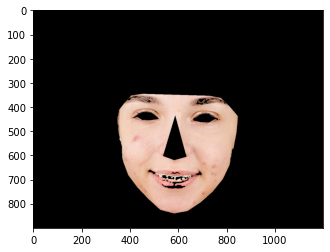

In [41]:
if __name__ == "__main__":
    
    #Read Image
    img = cv2.imread('data/acne_face.jpeg')
#     img = imutils.resize(img, width=300)
    img,Gimg = img2Gray(img)
    
#     # Method 1 to get face (Skin Detection and Face Detection(Harr))
#     skinMask = GetSkinMask(img)
#     faceMask = GetFaceMask(img)
#     # combine two mask
#     Face_Skin_Mask = cv2.bitwise_and(skinMask, faceMask)
#     img = cv2.bitwise_and(Face_Skin_Mask, img)
#     # can't cut out only face in result

    # Method 2 to get face (Use Dlib)
    SkinMask = GetSkinMask(img)
    landmarks = get_landmarks(Gimg)
    faceMask = get_image_hull_mask(img, landmarks)
    img = cv2.bitwise_and(faceMask, img)
    img = cv2.bitwise_and(SkinMask, img)
    # not a good method, which cost 1.55 sec

    
    
    cv2.imwrite('ClearMask.png', img)
    showImage(img)


    

Frames per second using cv2.CAP_PROP_FPS : nan


TypeError: '_dlib_pybind11.full_object_detection' object is not callable

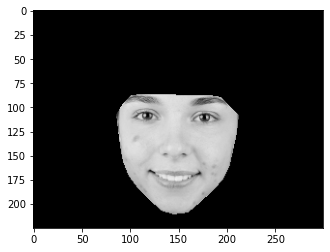